# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using 

1. Clean the data and perform some EDA and visualization to get to know the data set.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         976 non-null    int64 
 1   Make               976 non-null    object
 2   Make_Year          976 non-null    int64 
 3   Color              976 non-null    object
 4   Body_Type          976 non-null    object
 5   Mileage_Run        976 non-null    int64 
 6   No_of_Owners       976 non-null    object
 7   Seating_Capacity   976 non-null    int64 
 8   Fuel_Type          976 non-null    object
 9   Transmission       976 non-null    object
 10  Transmission_Type  976 non-null    object
 11  Price              976 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 91.6+ KB
None
       Unnamed: 0    Make_Year   Mileage_Run  Seating_Capacity         Price
count  976.000000   976.000000    976.000000        976.000000  9.760000e+02
mean   488.500000  2016.963

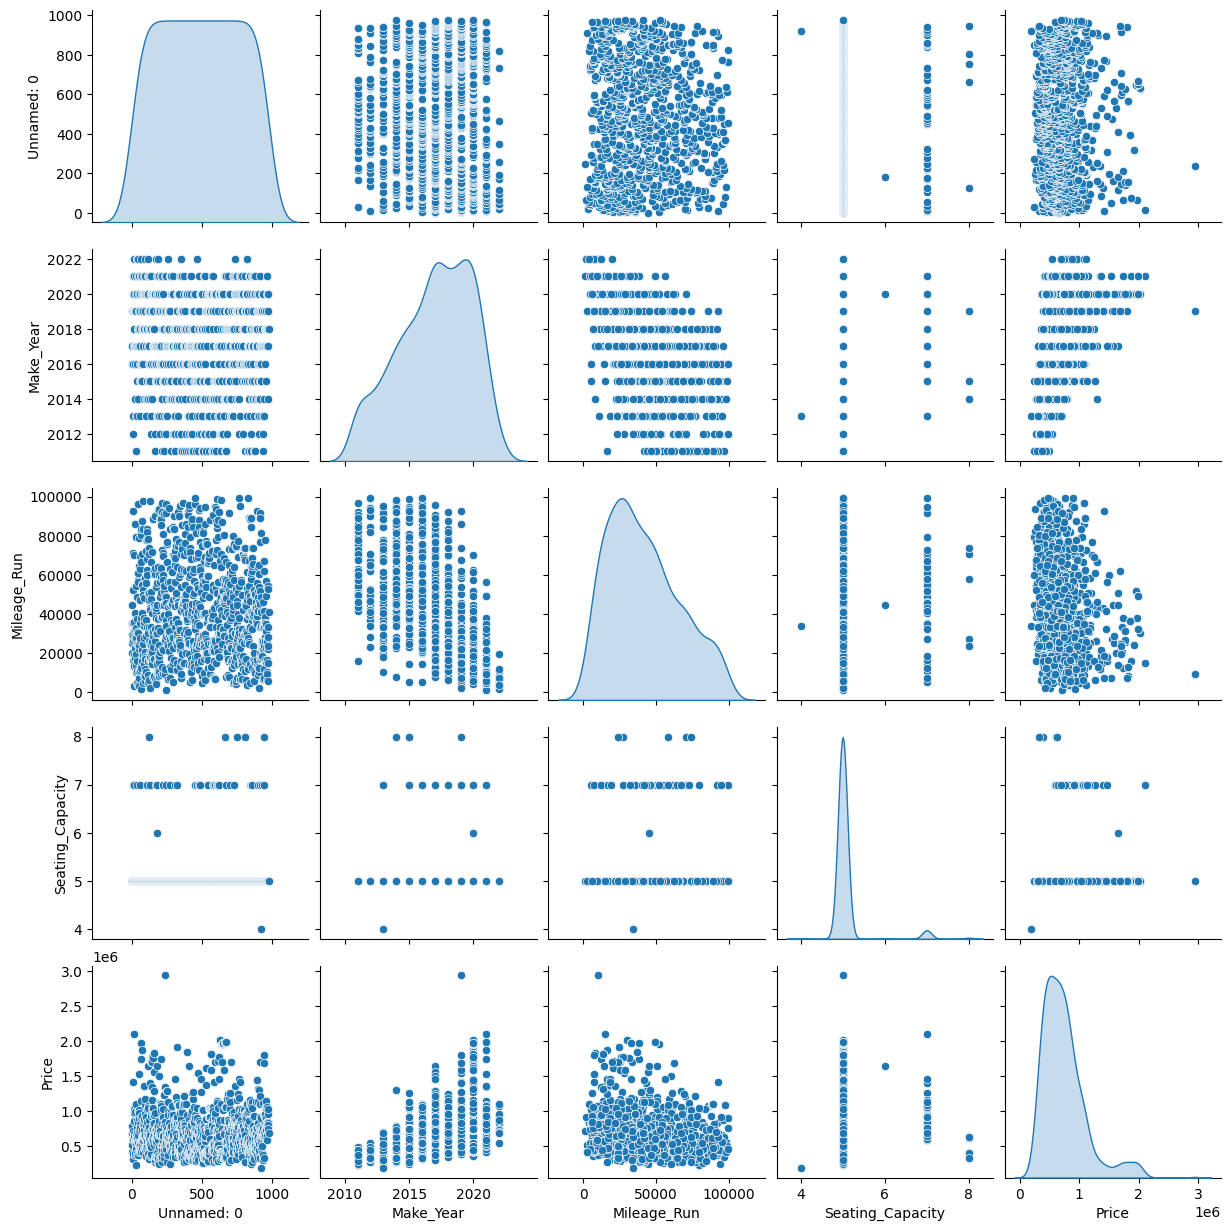

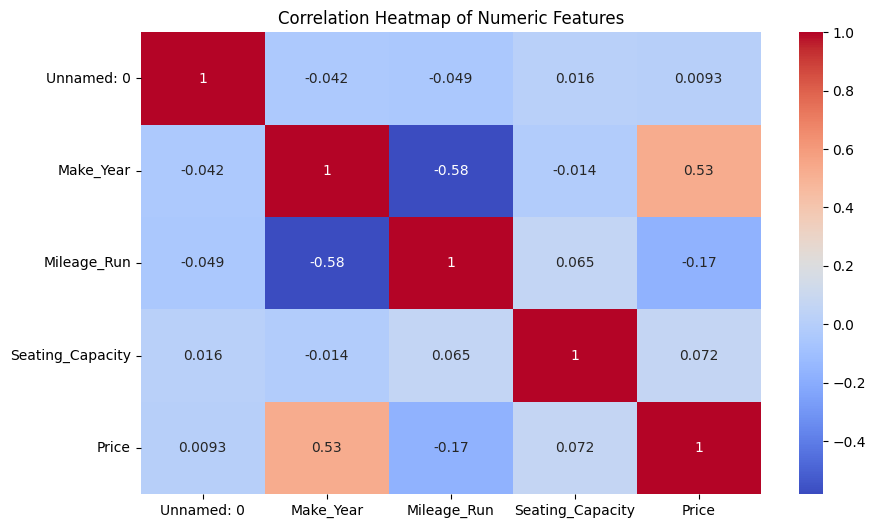

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/calebkim7/lab_hedonic_pricing/data/cars_hw.csv")

# View structure
print(df.info())
print(df.describe())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Handle missing values if any
df = df.dropna() 

sns.pairplot(df, diag_kind='kde')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [3]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", cat_cols)

# One-hot encode
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Categorical Columns: Index(['Make', 'Color', 'Body_Type', 'No_of_Owners', 'Fuel_Type',
       'Transmission', 'Transmission_Type'],
      dtype='object')


3. Implement an 80/20 train-test split. Put the test data aside.

In [5]:
from sklearn.model_selection import train_test_split

# Assume the target is 'price'
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Helper function to evaluate models
def evaluate_linear_model(X_train, X_test, y_train, y_test, feature_list, model_name):
    lr = LinearRegression()
    lr.fit(X_train[feature_list], y_train)

    y_train_pred = lr.predict(X_train[feature_list])
    y_test_pred = lr.predict(X_test[feature_list])

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    return {
        "Model": model_name,
        "Train RMSE": rmse_train,
        "Test RMSE": rmse_test,
        "Train R²": r2_train,
        "Test R²": r2_test
    }

# Build multiple simple linear models (no transformations)
results = []

# Model 1: Mileage only
results.append(
    evaluate_linear_model(X_train, X_test, y_train, y_test,
                          ['Mileage_Run'], "Model 1: Mileage only")
)

# Model 2: Mileage + Year
results.append(
    evaluate_linear_model(X_train, X_test, y_train, y_test,
                          ['Mileage_Run', 'Make_Year'], "Model 2: Mileage + Year")
)

# Helper: get any column that starts with 'No_of_Owners'
owner_cols = [col for col in X_train.columns if col.startswith('No_of_Owners')]
print("Owner columns in encoded data:", owner_cols)

# Model 3: Mileage + Year + No_of_Owners + Seating_Capacity
base_features = ['Mileage_Run', 'Make_Year']
owner_features = owner_cols  # all dummy columns for No_of_Owners
seat_feature = ['Seating_Capacity'] if 'Seating_Capacity' in X_train.columns else []

model3_features = base_features + owner_features + seat_feature

results.append(
    evaluate_linear_model(
        X_train, X_test, y_train, y_test,
        model3_features,
        "Model 3: Add Owners & Seats"
    )
)

# Model 4: Add Fuel_Type and Transmission_Type dummy variables
fuel_trans_cols = [col for col in X_train.columns if 'Fuel_Type' in col or 'Transmission_Type' in col]
results.append(
    evaluate_linear_model(X_train, X_test, y_train, y_test,
                          ['Mileage_Run', 'Make_Year'] + fuel_trans_cols,
                          "Model 4: + Fuel & Transmission")
)

# Model 5: All features
results.append(
    evaluate_linear_model(X_train, X_test, y_train, y_test,
                          X_train.columns.tolist(), "Model 5: All features")
)

# Display comparison table ---
results_df = pd.DataFrame(results)
print("\n=== Linear Model Comparison (No Transformations/Interactions) ===")
print(results_df)

# Identify best model ---
best_model = results_df.loc[results_df['Test R²'].idxmax()]
print("\nBest Model Based on Test R²:")
print(best_model)

Owner columns in encoded data: ['No_of_Owners_2nd', 'No_of_Owners_3rd']

=== Linear Model Comparison (No Transformations/Interactions) ===
                            Model     Train RMSE      Test RMSE  Train R²  \
0           Model 1: Mileage only  369437.232061  330349.982458  0.022186   
1         Model 2: Mileage + Year  310695.036967  283873.728209  0.308418   
2     Model 3: Add Owners & Seats  308967.583583  284970.286399  0.316087   
3  Model 4: + Fuel & Transmission  276022.049057  266355.902298  0.454164   
4           Model 5: All features  141148.292043  145117.594262  0.857266   

    Test R²  
0  0.048514  
1  0.297407  
2  0.291968  
3  0.381445  
4  0.816391  

Best Model Based on Test R²:
Model         Model 5: All features
Train RMSE            141148.292043
Test RMSE             145117.594262
Train R²                   0.857266
Test R²                    0.816391
Name: 4, dtype: object


Model 5, or the model using all features, performs the best as it has the lowest Test RMSE and the highest Test R^2. The small difference between training and test performance suggests that there is no major overfitting.

5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 

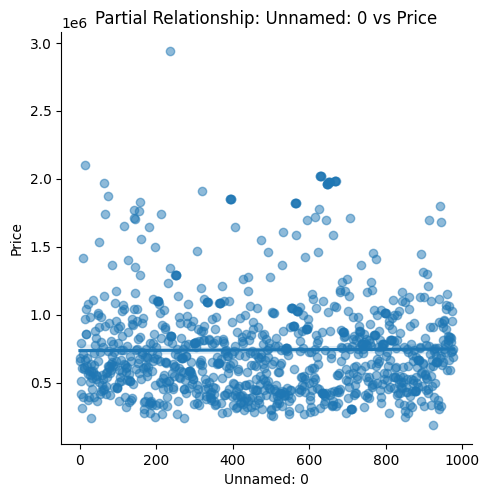

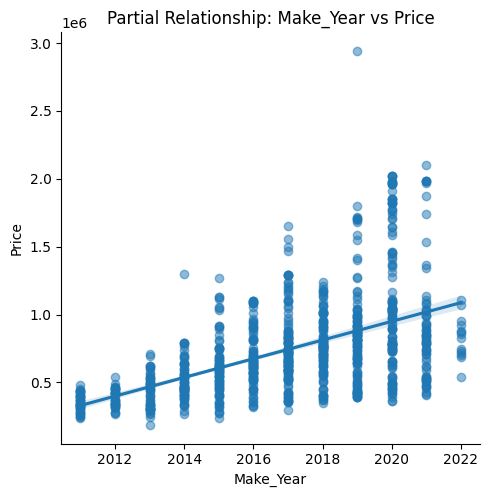

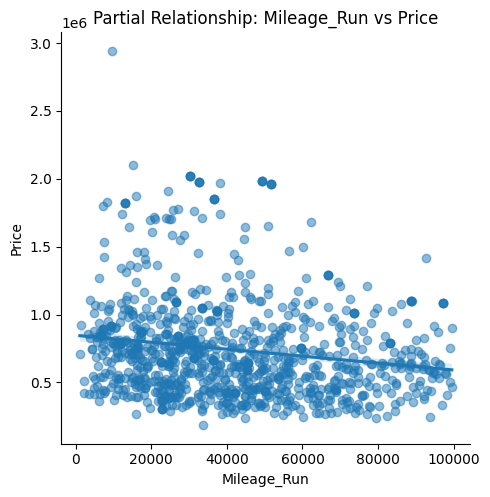

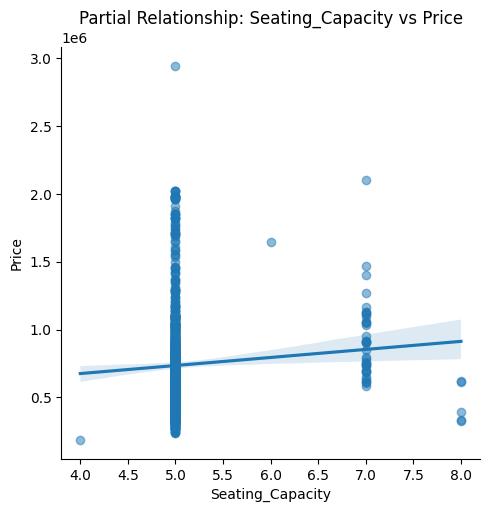

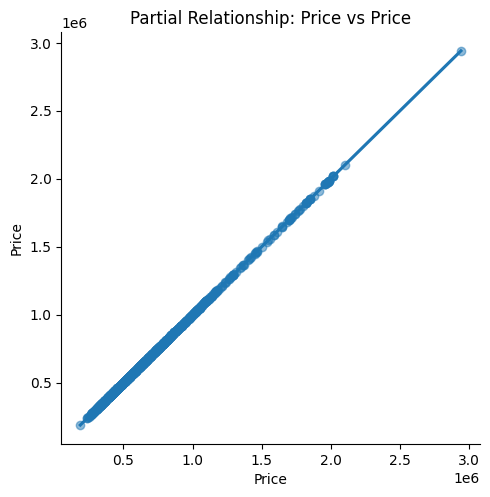

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    if col != 'price':
        sns.lmplot(x=col, y='Price', data=df, scatter_kws={'alpha':0.5})
        plt.title(f'Partial Relationship: {col} vs Price')
        plt.show()

Unnamed: 0 vs Price shows random scatter and no correlation with price. Make_Year vs Price shows a strong positive linear relationship where newer cars tend to have higher prices. Mileage_Run vs Price shows a negative relationship, meaning higher mileage corresponds to lower price generally. Seating_Capacity vs Price shows a weak upward slope. Most data points cluster at specific seat counts.

6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [13]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Add a log transformation for Mileage_Run (avoid log(0))
X_train['log_Mileage_Run'] = np.log1p(X_train['Mileage_Run'])
X_test['log_Mileage_Run'] = np.log1p(X_test['Mileage_Run'])

# Create polynomial + interaction features for selected numeric variables
poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Choose a subset of numeric features for polynomial expansion
poly_cols = ['Make_Year', 'log_Mileage_Run', 'Seating_Capacity']
X_train_poly = poly_features.fit_transform(X_train[poly_cols])
X_test_poly = poly_features.transform(X_test[poly_cols])

# Get the names of the generated polynomial features
poly_feature_names = poly_features.get_feature_names_out(poly_cols)

# Combine with the original dataset
X_train_complex = pd.concat([
    X_train.reset_index(drop=True),
    pd.DataFrame(X_train_poly, columns=poly_feature_names)
], axis=1)

X_test_complex = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(X_test_poly, columns=poly_feature_names)
], axis=1)

lr_complex = LinearRegression()
lr_complex.fit(X_train_complex, y_train)

# Predictions
y_train_pred = lr_complex.predict(X_train_complex)
y_test_pred = lr_complex.predict(X_test_complex)

# Evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Complex Model (Transformations + Interactions) Results:")
print(f"Train RMSE: {rmse_train:.2f}, R²: {r2_train:.3f}")
print(f"Test RMSE: {rmse_test:.2f}, R²: {r2_test:.3f}")



Complex Model (Transformations + Interactions) Results:
Train RMSE: 137329.43, R²: 0.865
Test RMSE: 144200.78, R²: 0.819


The more complex model that included transformations and interaction terms performed slightly better that the simpler linear model. The Train R^2 improved and the Test R^2 increased. Both RMSE values decreased. This indicates that log transformation of mileage and polynomial or interaction effects captured a bit more variation in car prices wiithout causing overfitting. 

7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?

The analysis showed that car prices are mostly influenced by manufacturing year and mileage, with newer cars generally priced higher and higher mileage leading to lower prices. Simple linear models progressively improved as more relevant features were added. And the full model achieved strong performance with a Test R² of about 0.816 and RMSE around 145,000. In addition, transformations and interaction terms slightly enhanced accuracy. Overall, the results show that while complex models can capture minor non-linear relationships, a well-specified linear model already provides strong predictive performance.

8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [14]:
from sklearn.linear_model import LassoCV

X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

# Split again to be sure
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit Lasso regression with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Predictions
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

# Evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Lasso Model Results:")
print(f"Best Alpha (λ): {lasso.alpha_:.4f}")
print(f"Train RMSE: {rmse_train:.2f}, R²: {r2_train:.3f}")
print(f"Test RMSE: {rmse_test:.2f}, R²: {r2_test:.3f}")

# Identify selected (non-zero) features
selected_features = pd.Series(lasso.coef_, index=X_train.columns)
selected_features = selected_features[selected_features != 0].sort_values(ascending=False)
print("\nSelected Predictive Features:")
print(selected_features)

Lasso Model Results:
Best Alpha (λ): 5075510.4725
Train RMSE: 369437.29, R²: 0.022
Test RMSE: 330370.27, R²: 0.048

Selected Predictive Features:
Mileage_Run   -2.288457
dtype: float64
